# DayFilter Process Implementation on a Univariate Dataset of Chiller Plant Data

## Part 2 - Motif Candidate Clustering

This analysis was prepared by [Clayton Miller](https://www.researchgate.net/profile/Clayton_Miller2)
as part of a series of Commercial Open Building Datasets on [datadrivenbuilding.org](http://datadrivenbuilding.org/) This notebook will implement the first part of the DayFilter Process on data from the [United World College of South East Asia Tampines Campus in Singapore](https://www.uwcsea.edu.sg/east-campus) tilizing the [United World College of South East Asia - Open data to faciliate research and development](http://datadrivenbuilding.org/United-World-College-Campus)

### The DayFilter Process is outlined an [Automation in Construction publication](https://www.researchgate.net/publication/266616977_Automated_daily_pattern_filtering_of_measured_building_performance_data) -- the dataset used in this notebook is identical to that illustrated in the paper.

## Goal of the notebook:

The goal of this notebook is to take the *motif candidates* from Part 1 and further aggregate them using the very common, K-means algorithm.

This dataset is downloadable [here](https://www.dropbox.com/s/30nkwi671ad6lpe/RawData.zip?dl=0) and is licensed under a [Creative Commons Attribution-NonCommercial 3.0 Unported License](http://creativecommons.org/licenses/by-nc/3.0/). 

First, we load the appropriate libaries -- including the following external (and very important libraries):
- [Pandas](http://pandas.pydata.org/)
- [matplotlib](http://matplotlib.org/)

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import json
from datetime import datetime

In [2]:
%matplotlib inline

We need a function from the [Scipy](http://www.scipy.org/) library to do the k-means transformation:

In [3]:
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from sklearn import metrics
import numpy as np

We'll also use the statistics visualization libary [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/):

In [31]:
import seaborn as sns
sns.set_context(context='talk', font_scale=2)

## Load and explore the data

Let's grab the motif candidates from output file from Part 1: `"MotifProfiles.csv"`

In [32]:
df = pd.read_csv("./MotifProfiles.csv", parse_dates=True, index_col='Date')

In [33]:
df.head()

,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,SAXstring
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-12,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,abba
2012-07-13,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,abba
2012-07-14,0.0,0.0,0.0,86.39,204.552,195.21,100.436,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aaaa
2012-07-15,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,aaaa
2012-07-16,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,abba


In [34]:
df = df.drop(['SAXstring'], axis=1)

First, we have to 'unpivot' the data and return it to a timestamp format

In [35]:
def timestampcombine_parse(date,time):
    #timestampstring = date+" "+time
#     date = datetime.strptime(date, "%Y-%M-%d")
    time = datetime.strptime(time, "%H:%M:%S").time()
    pydatetime = datetime.combine(date, time)

    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [36]:
df = df.T.unstack().reset_index()
df['timestampstring'] = map(timestampcombine_parse, df.Date, df.level_1)
df.index = df.timestampstring
df = df.drop(['Date','level_1','timestampstring'],axis=1)
df.columns = ["CP_TotalChiller_kW"]
df = df.resample('H').mean()

In [37]:
df.head()

,CP_TotalChiller_kW
timestampstring,
2012-07-12 00:00:00,0.0
2012-07-12 01:00:00,0.0
2012-07-12 02:00:00,0.0
2012-07-12 03:00:00,0.0
2012-07-12 04:00:00,0.0


Now we'll cluster using a function in which the number of clusters can be varied and quality metrics are calculated

Now we have a function for visualizing and outputting pdf files

Prepare the data and Set the parameters for clustering:

In [38]:
df_norm = (df - df.mean()) / (df.max() - df.min()) #normalized

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [39]:
dailyblocks = pd.pivot_table(df, values='CP_TotalChiller_kW', index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values='CP_TotalChiller_kW', index='Date', columns='Time', aggfunc='mean')

## K-Means Clustering of Daily Profiles

Details of the *how* and *why* to do K-means clustering can be found in the paper and [online](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

First we use the SciPy library to do the k-means clustering. We will choose to create 5 clusters in this situation. We start out with a set of daily profiles at 15 min intervals - each 15 min interval reading is an input feature for k-means:

In [40]:
dailyblocks_norm.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-12,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.053264,...,0.072850,0.063496,-0.029208,-0.058662,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996
2012-07-13,-0.236996,-0.236996,-0.151471,-0.146850,-0.236996,-0.236996,-0.236996,-0.143838,0.096622,0.217350,...,0.123324,0.153482,0.045899,-0.142774,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996
2012-07-14,-0.210707,-0.084784,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,...,-0.236996,-0.236996,-0.236996,-0.236996,-0.042780,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996
2012-07-15,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.099143,-0.196988,-0.236996,...,-0.236996,-0.236996,-0.236996,-0.236996,-0.101690,-0.208043,-0.236996,-0.236996,-0.236996,-0.236996
2012-07-16,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.101637,-0.113970,0.017248,0.300716,...,0.113872,0.119263,0.047630,-0.146093,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996,-0.236996


In [41]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [42]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

Combine the output back with the dataset

In [43]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

In [44]:
dailyclusters.head()

Time,Date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,ClusterNo
0,2012-07-12,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.000000,...,246.868000,170.7075,146.5095,0.0000,0.0000,0.0,0.0,0.0,0.0,1
1,2012-07-13,0.0000,0.0000,70.2625,74.0595,0.0,0.0,0.0000,76.5335,274.082500,...,320.795998,232.4110,77.4075,0.0000,0.0000,0.0,0.0,0.0,0.0,1
2,2012-07-14,21.5975,125.0495,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.000000,...,0.000000,0.0000,0.0000,159.5575,0.0000,0.0,0.0,0.0,0.0,2
3,2012-07-15,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,113.2530,32.868500,...,0.000000,0.0000,0.0000,111.1600,23.7865,0.0,0.0,0.0,0.0,2
4,2012-07-16,0.0000,0.0000,0.0000,0.0000,0.0,0.0,111.2035,101.0715,208.873499,...,292.683000,233.8335,74.6810,0.0000,0.0000,0.0,0.0,0.0,0.0,1


Notice the last column is the cluster number assigned by the k-means process. We'll first reorder the clustering numbers so that the greatest consuming clusters have the highest numbers:

In [45]:
x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).sort_values()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [46]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort_index()

In [47]:
dailyclusters.head()

ClusterNo2          1                                                         \
Date       2012-07-12 2012-07-13 2012-07-16 2012-07-17 2012-07-18 2012-07-19   
Time                                                                           
00:00:00          0.0     0.0000        0.0        0.0        0.0        0.0   
01:00:00          0.0     0.0000        0.0        0.0        0.0        0.0   
02:00:00          0.0    70.2625        0.0        0.0        0.0        0.0   
03:00:00          0.0    74.0595        0.0        0.0        0.0        0.0   
04:00:00          0.0     0.0000        0.0        0.0        0.0        0.0   

ClusterNo2                                                ...              3  \
Date       2012-07-20 2012-07-23 2012-07-24 2012-07-25    ...     2014-02-18   
Time                                                      ...                  
00:00:00          0.0        0.0        0.0        0.0    ...        81.9945   
01:00:00          0.0        0.0        0.0        0.0    ...        85.8995   
02:00:00          0.0        0.0        0.0        0.0    ...         0.0000   
03:00:00          0.0        0.0        0.0        0.0    ...        14.6915   
04:00:00          0.0        0.0        0.0        0.0    ...       150.8915   

ClusterNo2                                                                    \
Date       2014-03-14 2014-03-18 2014-03-19 2014-03-20 2014-03-21 2014-03-25   
Time                                                                           
00:00:00      90.8880    73.6895    81.2285  90.275500   146.9525     0.0000   
01:00:00      93.8430   105.6110   110.5580  88.453000     0.0000   141.2995   
02:00:00       0.0000     0.0000     0.0000  87.143001     0.0000    41.5885   
03:00:00      32.3320     0.0000    50.3485  87.733002   149.1345     0.0000   
04:00:00     139.5955   178.1300   140.2180  88.305501    21.6155   101.7185   

ClusterNo2                                   
Date       2014-03-26 2014-03-27 2014-03-28  
Time                                         
00:00:00       0.0000     0.0000    158.684  
01:00:00     122.5335   158.7015     31.039  
02:00:00      65.3415    29.3350      0.000  
03:00:00       0.0000     0.0000    121.116  
04:00:00      81.0005   104.4720     67.997  

[5 rows x 605 columns]

Now we have a dataframe with each of the clusters hiearchically divided -- let's visualize what the clusters. First, let's look at all the profiles at once divided according to cluster:

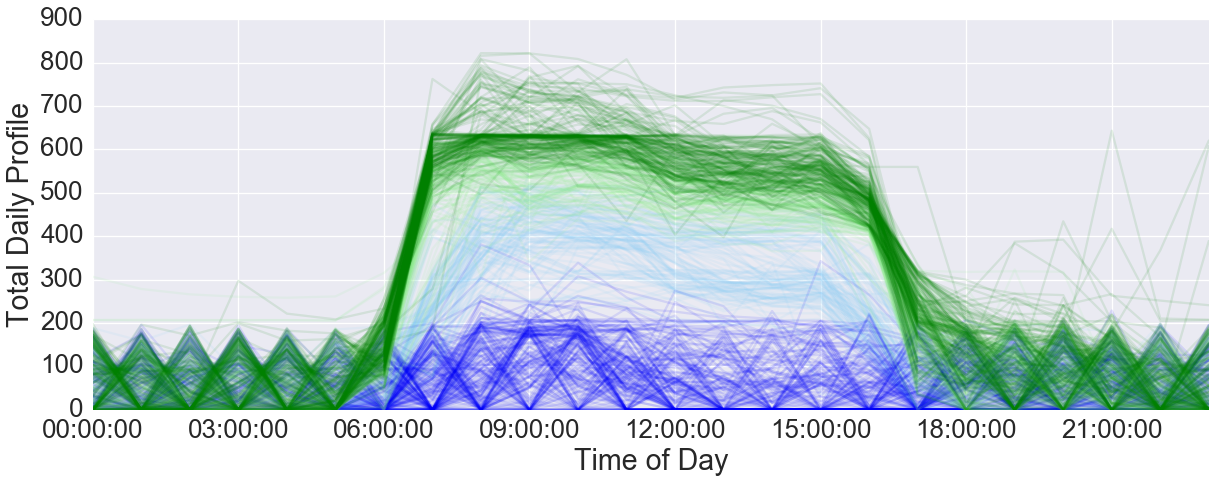

In [48]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 20, 7

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 10800))

ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day')
plt.savefig("./graphics/clusters_total_overlaid_profiles.png")

Now, let's aggregate and visualize the clusters as they exist across the time range:

In [49]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.Time)
    df = df.dropna()
    return df

In [50]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

In [51]:
dailyclusters.head()

ClusterNo2          1                                                         \
Date       2012-07-12 2012-07-13 2012-07-16 2012-07-17 2012-07-18 2012-07-19   
Time                                                                           
00:00:00          0.0     0.0000        0.0        0.0        0.0        0.0   
01:00:00          0.0     0.0000        0.0        0.0        0.0        0.0   
02:00:00          0.0    70.2625        0.0        0.0        0.0        0.0   
03:00:00          0.0    74.0595        0.0        0.0        0.0        0.0   
04:00:00          0.0     0.0000        0.0        0.0        0.0        0.0   

ClusterNo2                                                ...              3  \
Date       2012-07-20 2012-07-23 2012-07-24 2012-07-25    ...     2014-02-18   
Time                                                      ...                  
00:00:00          0.0        0.0        0.0        0.0    ...        81.9945   
01:00:00          0.0        0.0        0.0        0.0    ...        85.8995   
02:00:00          0.0        0.0        0.0        0.0    ...         0.0000   
03:00:00          0.0        0.0        0.0        0.0    ...        14.6915   
04:00:00          0.0        0.0        0.0        0.0    ...       150.8915   

ClusterNo2                                                                    \
Date       2014-03-14 2014-03-18 2014-03-19 2014-03-20 2014-03-21 2014-03-25   
Time                                                                           
00:00:00      90.8880    73.6895    81.2285  90.275500   146.9525     0.0000   
01:00:00      93.8430   105.6110   110.5580  88.453000     0.0000   141.2995   
02:00:00       0.0000     0.0000     0.0000  87.143001     0.0000    41.5885   
03:00:00      32.3320     0.0000    50.3485  87.733002   149.1345     0.0000   
04:00:00     139.5955   178.1300   140.2180  88.305501    21.6155   101.7185   

ClusterNo2                                   
Date       2014-03-26 2014-03-27 2014-03-28  
Time                                         
00:00:00       0.0000     0.0000    158.684  
01:00:00     122.5335   158.7015     31.039  
02:00:00      65.3415    29.3350      0.000  
03:00:00       0.0000     0.0000    121.116  
04:00:00      81.0005   104.4720     67.997  

[5 rows x 605 columns]

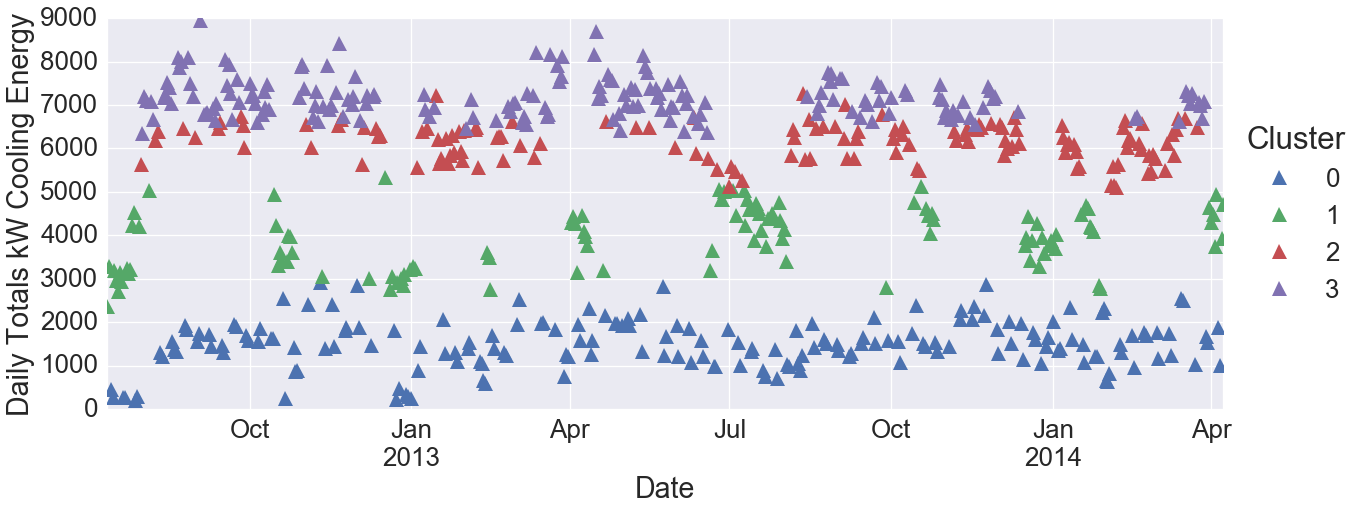

In [52]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

clusteravgplot = dfclusterunstackedpivoted.resample('D').sum().plot(style="^",markersize=15)
clusteravgplot.set_ylabel('Daily Totals kW Cooling Energy')
clusteravgplot.set_xlabel('Date')
clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

plt.savefig("./graphics/clusters_overtime.png")

Let's look at the average profiles of each cluster:

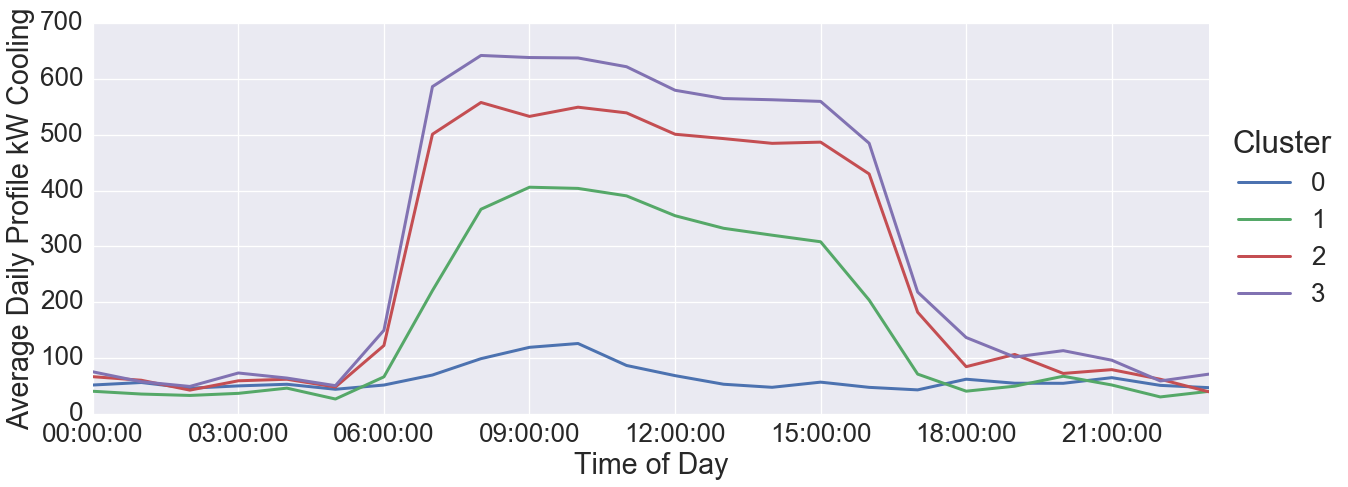

In [53]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),linewidth=3, xticks=np.arange(0, 86400, 10800))
dailyprofile.set_ylabel('Average Daily Profile kW Cooling')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("./graphics/clusters_averagedprofiles.png")

Let's look at the tendency for the clusters to exist within certain days

In [54]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').mean().reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

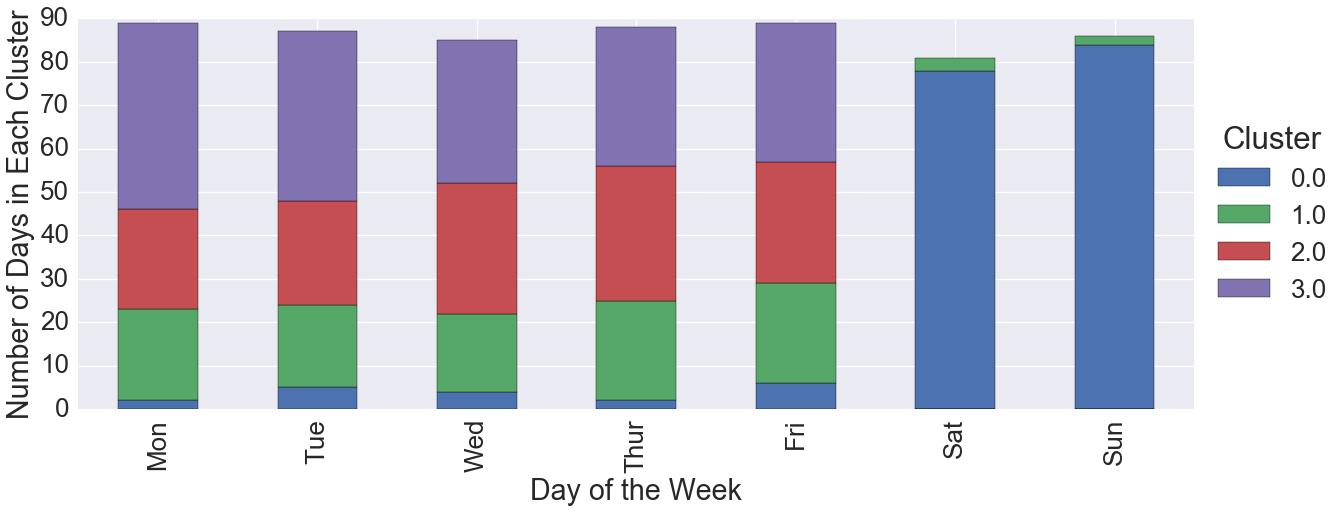

In [55]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsClusterplot1 = DayVsCluster.plot(figsize=(20,7),kind='bar',stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
plt.savefig("./graphics/clusters_dailybreakdown.png")

Looks like there are typical weekday vs. weekend types which is not surprising. 

Let's get an idea of how many days are contained in each cluster

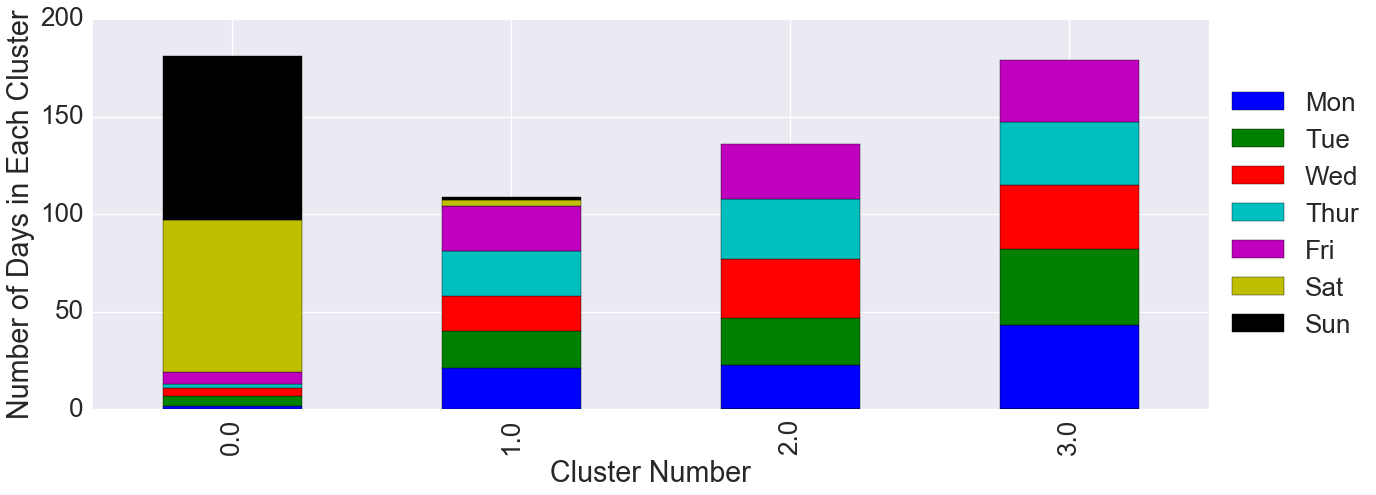

In [56]:
DayVsClusterplot2 = DayVsCluster.T.plot(figsize=(20,7),kind='bar',stacked=True, color=['b','g','r','c','m','y','k']) #, color=colors2
DayVsClusterplot2.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot2.set_xlabel('Cluster Number')
DayVsClusterplot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("./graphics/cluster_numberofdays.png")

## K-means Clustering Process

We cycled through and completed the clustering process step by step for 4 clusters -- let's now look at automating the process of creating multiple `k` settings.

The fuctions and loop is set up to calculate a range of `k` clusters -- the following settings will only run by choosing 5-7 clusters. You can increase the number of clusters created by change the `range(x1,x2)` -- for example `range(4,7)` would rerun the process for 4, 5, and 6 clusters

In [57]:
AnalysisLabel = "UWC Chiller kW"

In [58]:
NumberOfClusterList = range(5,8)
KmeansIterationsSettingList = [10000]

In [69]:
#This clustermaker is modified to take a whole time series and pivot to day-types within the function.
#This allows normalization and silhouhette calculation within the function
def ClusterMaker2(dailyblocks, dailyblocks_norm, clusterno, iterations):
    
    dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
    #dailyblocks = whiten(dailyblocks)
    centers, _ = kmeans(dailyblocksmatrix_norm, clusterno, iter=iterations)
    cluster, _ = vq(dailyblocksmatrix_norm, centers)
    
    #Calc Silhouette Coeff for each sample
    silhouttecoeff = metrics.silhouette_samples(dailyblocksmatrix_norm, cluster, metric='euclidean')
    silhouettecoeffscore = metrics.silhouette_score(dailyblocksmatrix_norm, cluster, metric='euclidean')
    
    #Calc Average within-cluster sum of squares
    Distance = cdist(dailyblocksmatrix_norm, centers, 'euclidean')
    #cIdx = np.argmin(Distance,axis=1)
    dist = np.min(Distance, axis=1)
    AvgWithinSS = sum(dist)/dailyblocksmatrix_norm.shape[0]
    
    clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])
    
    dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 
    dailyclusters_norm = pd.concat([dailyblocks_norm.dropna().reset_index(), clusterdf], axis=1)
    
    #Reorder the cluster numbers so that the largest clusters are the highest numbers
    x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).sort_values()
    x = pd.DataFrame(x.reset_index())
    x['ClusterNo2'] = x.index
    x = x.set_index('ClusterNo')
    x = x.drop([0], axis=1)
    dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)
    
    #dailyclusters['Date2'] = pd.to_datetime(dailyclusters['Date'])
    #dailyclusters['ClusterNo2'] = dailyclusters['ClusterNo2'].astype(float)
    
    dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
    dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort_index()

    return dailyclusters, silhouttecoeff, silhouettecoeffscore, AvgWithinSS

In [73]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    #pydatetime = pydatetime.replace(tzinfo=pytz.UTC)
    #return pydatetime.astimezone(singaporezone).replace(tzinfo=None)
    return pydatetime

def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = map(timestampcombine, df.Date, df.Time)
    df = df.dropna()
    return df

def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').mean().reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

def ClusterAnalysisProcess(dfclusters, clusterno, noofiterations, nameofanalysis):
    #plt.get_cmap('Blues')
    Analysisname = nameofanalysis+'_'+str(clusterno)+'Clusters_'+str(noofiterations)+'Iterations'
    pp = PdfPages('./graphics/'+Analysisname+'.pdf')
    max_sec = 86400
    
    clusterlist = list(dfclusters.columns.get_level_values(0).unique())
    #rcParams['figure.figsize'] = 20, 7
    styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
    fig, ax = plt.subplots()
    for col, style in zip(clusterlist, styles2):
        dfclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, max_sec, 10800))
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Total Daily Profile')
    ax.set_xlabel('Time of Day')
    pp.savefig()
        
    dfclusterunstacked = ClusterUnstacker(dfclusters)
    dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, rows='timestampstring', cols='ClusterNo2')
    
    clusteravgplot = dfclusterunstackedpivoted.resample('D').mean().plot(style="^",markersize=15)
    clusteravgplot.set_ylabel('Daily Totals '+nameofanalysis)
    clusteravgplot.set_xlabel('Date')
    clusteravgplot.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
    pp.savefig()
    
    dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
    dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),linewidth=3, xticks=np.arange(0, max_sec, 10800))
    dailyprofile.set_ylabel('Average Daily Profile '+nameofanalysis)
    dailyprofile.set_xlabel('Time of Day')
    dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
    #dailyprofile.xaxis.set_major_locator(dates.HourLocator())
    pp.savefig()

    DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
    DayVsClusterplot1 = DayVsCluster.plot(figsize=(20,7),kind='bar',stacked=True)
    DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster '+nameofanalysis)
    DayVsClusterplot1.set_xlabel('Day of the Week')
    DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
    pp.savefig()

    DayVsClusterplot2 = DayVsCluster.T.plot(figsize=(20,7),kind='bar',stacked=True, color=['b','g','r','c','m','y','k']) #, color=colors2
    DayVsClusterplot2.set_ylabel('Number of Days in Each Cluster '+nameofanalysis)
    DayVsClusterplot2.set_xlabel('Cluster Number')
    DayVsClusterplot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    pp.savefig()
    pp.close()
    
    ClustersForExport = dfclusters.T.reset_index()
    #ClustersForExport = ClustersForExport[['Date','ClusterNo']] 
    ClustersForExport.to_csv(Analysisname+'Clusters.csv')
    
    dfclusterunstackedpivoted.to_csv(Analysisname+'PivotedClusters.csv')

    return DayVsCluster, dfclusterunstackedpivoted

In [74]:
SilhouetteMetricsList = []

Running clustering with 5 Clusters and 10000 Iteration Setting


TypeError: pivot_table() got an unexpected keyword argument 'rows'

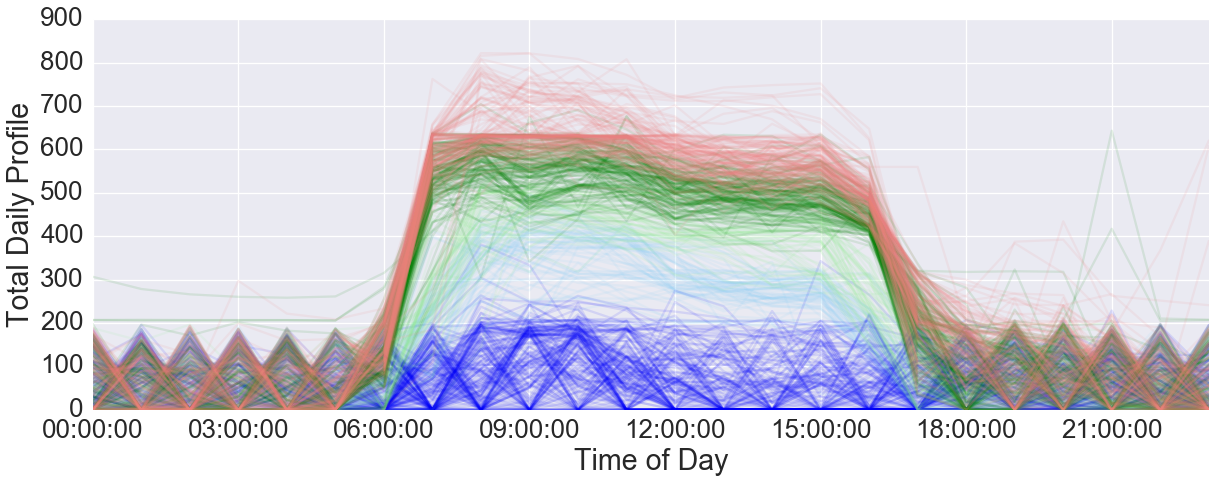

In [75]:
for NumberOfClusters in NumberOfClusterList:
    for KmeansIterationsSetting in KmeansIterationsSettingList:
        print("Running clustering with "+str(NumberOfClusters)+" Clusters and "+str(KmeansIterationsSetting)+" Iteration Setting")
        TotalClusters, SilCoeff, SilScore, AvgWithinSS = ClusterMaker2(dailyblocks, dailyblocks_norm, NumberOfClusters, KmeansIterationsSetting)
        TotalDayVsCluster, TotalClusterStackedPivoted = ClusterAnalysisProcess(TotalClusters, NumberOfClusters, KmeansIterationsSetting, AnalysisLabel)
        
        Silhouttedf = pd.DataFrame(SilCoeff, columns=['SilCoeff'])
        ClusterQual = pd.concat([TotalClusters.T.reset_index(), Silhouttedf], axis=1)
        
        Analysisname = AnalysisLabel+'_Silhouette_'+str(NumberOfClusters)+'_'+str(KmeansIterationsSetting)
        ClusterQual.to_csv(Analysisname+'.csv')
        
        ClusterQualSummary = ClusterQual.groupby(by='ClusterNo2').mean()
        SilhouetteMetricsList.append([NumberOfClusters, KmeansIterationsSetting, ClusterQualSummary.T.ix['SilCoeff'].mean(), SilScore, AvgWithinSS])